In [ ]:
# !unzip /content/Toy_problem_VRP.zip -d /content/Toy_problem_VRP

In [ ]:
!unzip /content/mygeodata.zip -d /content/Geojson_data

Archive:  /content/mygeodata.zip
  inflating: /content/Geojson_data/destination point.geojson  
  inflating: /content/Geojson_data/origin point.geojson  
  inflating: /content/Geojson_data/road network fin.geojson  


In [ ]:
# !pip install geopandas
# !pip install networkx

In [ ]:
import geopandas as gpd

import networkx as nx
from shapely.geometry import LineString,point,Point

import matplotlib.pyplot as plt

from shapely.ops import unary_union, nearest_points
import random
import math

#Load data

In [ ]:
path = "/content/Toy_problem_VRP/"
geo_path = "/content/Geojson_data/"

destination_path = geo_path + "destination point.geojson"
origin_path = geo_path + "origin point.geojson"
road_network_path = geo_path + "road network fin.geojson"

In [ ]:
# Load the datasets
road_network = gpd.read_file(road_network_path)
origins = gpd.read_file(origin_path)
destinations = gpd.read_file(destination_path)

# Display first few rows
print("Road Network:")
display(road_network.head())

print("Origin Points:")
display(origins.head())

print("Destination Points:")
display(destinations.head())


Road Network:


,length,no,geometry
0,1633.648,1,"LINESTRING (87.3086 22.31986, 87.30846 22.3198..."
1,679.087,2,"LINESTRING (87.31555 22.32109, 87.31504 22.321..."
2,1250.464,3,"LINESTRING (87.30726 22.31713, 87.30993 22.317..."
3,29.747,4,"LINESTRING (87.31928 22.31871, 87.31945 22.318..."
4,928.862,5,"LINESTRING (87.30714 22.31704, 87.30626 22.315..."


Origin Points:


,id,layer,x,y,geometry
0,39,INSTITUTE,87.300818,22.318045,POINT (87.30082 22.31804)
1,6,HOSTEL,87.307806,22.319820,POINT (87.31831 22.30731)
2,1,HOSTEL,87.307674,22.321061,POINT (87.30769 22.32106)


Destination Points:


,id,destinatio,geometry
0,1,None,POINT (87.32778 22.31104)
1,4,metallurgical department,POINT (87.3136 22.32081)
2,6,nalanda complex,POINT (87.31731 22.31711)


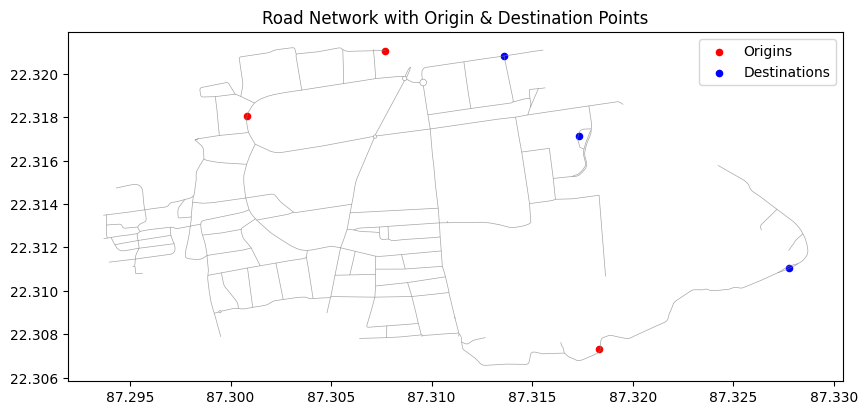

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the road network
road_network.plot(ax=ax, color="gray", linewidth=0.5, alpha=0.7)

# Plot origins and destinations
origins.plot(ax=ax, color="red", markersize=20, label="Origins")
destinations.plot(ax=ax, color="blue", markersize=20, label="Destinations")

plt.legend()
plt.title("Road Network with Origin & Destination Points")
plt.show()

# Find intersections

In [ ]:
# Create an empty graph
G = nx.Graph()

# Extract road geometries
road_lines = [LineString(feature.geometry) for feature in road_network.itertuples()]

# Find intersection points
intersections = set()
for i, line1 in enumerate(road_lines):
    for j, line2 in enumerate(road_lines):
        if i >= j:
            continue  # Avoid duplicate checks

        # Find intersection points
        intersection = line1.intersection(line2)

        # If intersection is a valid point (not a line or area)
        if isinstance(intersection, Point):
            intersections.add((intersection.x, intersection.y))

# Add intersections as nodes to the graph
for node in intersections:
    G.add_node(node)

print(f"✅ Found {len(intersections)} intersections.")

# Add origin points as nodes to the graph
for _, origin in origins.iterrows():
    origin_coords = (origin.geometry.x, origin.geometry.y)
    G.add_node(origin_coords)

# Add destination points as nodes to the graph
for _, destination in destinations.iterrows():
    destination_coords = (destination.geometry.x, destination.geometry.y)
    G.add_node(destination_coords)

print(f"✅ Added {len(origins)} origin points and {len(destinations)} destination points as nodes.")



✅ Found 138 intersections.
✅ Added 3 origin points and 3 destination points as nodes.


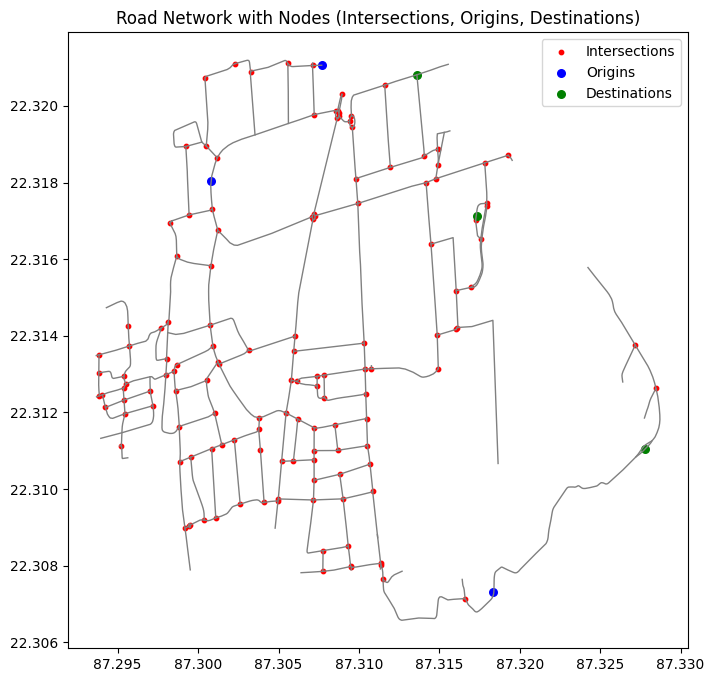

In [ ]:
# Visualize all nodes (intersections, origins, destinations)
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the road network lines
for line in road_lines:
    x, y = line.xy
    ax.plot(x, y, color="gray", linewidth=1)

# Plot intersection points in red
x_inter, y_inter = zip(*intersections)
ax.scatter(x_inter, y_inter, color="red", s=10, label="Intersections")

# Plot origin points in blue
x_orig, y_orig = zip(*[(origin.geometry.x, origin.geometry.y) for _, origin in origins.iterrows()])
ax.scatter(x_orig, y_orig, color="blue", s=30, label="Origins")

# Plot destination points in green
x_dest, y_dest = zip(*[(destination.geometry.x, destination.geometry.y) for _, destination in destinations.iterrows()])
ax.scatter(x_dest, y_dest, color="green", s=30, label="Destinations")

# # Plot all nodes from the graph
# for node in G.nodes:
#     ax.scatter(node[0], node[1], color="orange", s=20)

# Add legend and labels
plt.legend()
plt.title("Road Network with Nodes (Intersections, Origins, Destinations)")
plt.show()


#Add edges

In [ ]:
# ✅ Add edges between intersections
for i, row in road_network.iterrows():
    line = row.geometry
    road_length = row["length"]  # Use precomputed road length

    # Iterate over consecutive segment pairs
    for p1, p2 in zip(line.coords[:-1], line.coords[1:]):
        p1, p2 = Point(p1), Point(p2)

        # Find nearest intersection points
        nearest_p1 = nearest_points(p1, unary_union([Point(x, y) for x, y in intersections]))[1]
        nearest_p2 = nearest_points(p2, unary_union([Point(x, y) for x, y in intersections]))[1]

        if nearest_p1 != nearest_p2:
            G.add_edge((nearest_p1.x, nearest_p1.y), (nearest_p2.x, nearest_p2.y), weight=road_length)

In [ ]:
# Origins
G.add_edge((87.3008181, 22.3180446), (87.3011881, 22.3186459), weight=0.0007)
G.add_edge((87.3008181, 22.3180446), (87.3008856, 22.3173078), weight=0.0008)

G.add_edge((87.3183091, 22.307314), (87.3284675, 22.3126279), weight=0.001)
G.add_edge((87.3183091, 22.307314), (87.3166026, 22.307132), weight=0.001)

G.add_edge((87.3076863, 22.3210607), (87.3071132, 22.3210546), weight=0.0006)
G.add_edge((87.3076863, 22.3210607), (87.3072196, 22.3197718), weight=0.0009)

# Destinations
G.add_edge((87.3277825, 22.3110414), (87.3284675, 22.3126279), weight=0.001)
G.add_edge((87.3277825, 22.3110414), (87.3166026, 22.307132), weight=0.001)

G.add_edge((87.3173107, 22.3171132), (87.3172534, 22.3170132), weight=0.0005)
G.add_edge((87.3173107, 22.3171132), (87.3179339, 22.3173944), weight=0.0007)

print("✅ Added edges from origin and destination nodes to their nearest intersections.")


✅ Added edges from origin and destination nodes to their nearest intersections.


In [ ]:
# Print connected edges for each origin node
print("\n🔵 Edges connected to Origins:")
for _, row in origins.iterrows():
    origin_coords = (row.geometry.x, row.geometry.y)
    if origin_coords in G:
        edges = list(G.edges(origin_coords, data=True))
        print(f"Origin {origin_coords} connected to:")
        for u, v, data in edges:
            print(f"  → {v} (Distance: {data['weight']:.2f})")
    else:
        print(f"Origin {origin_coords} not found in graph.")

# Print connected edges for each destination node
print("\n🟢 Edges connected to Destinations:")
for _, row in destinations.iterrows():
    dest_coords = (row.geometry.x, row.geometry.y)
    if dest_coords in G:
        edges = list(G.edges(dest_coords, data=True))
        print(f"Destination {dest_coords} connected to:")
        for u, v, data in edges:
            print(f"  → {v} (Distance: {data['weight']:.2f})")
    else:
        print(f"Destination {dest_coords} not found in graph.")



🔵 Edges connected to Origins:
Origin (87.3008181, 22.3180446) connected to:
  → (87.3011881, 22.3186459) (Distance: 0.00)
  → (87.3008856, 22.3173078) (Distance: 0.00)
Origin (87.3183091, 22.307314) connected to:
  → (87.3284675, 22.3126279) (Distance: 0.00)
  → (87.3166026, 22.307132) (Distance: 0.00)
Origin (87.3076863, 22.3210607) connected to:
  → (87.3071132, 22.3210546) (Distance: 0.00)
  → (87.3072196, 22.3197718) (Distance: 0.00)

🟢 Edges connected to Destinations:
Destination (87.3277825, 22.3110414) connected to:
  → (87.3284675, 22.3126279) (Distance: 0.00)
  → (87.3166026, 22.307132) (Distance: 0.00)
Destination (87.3136019, 22.320812) connected to:
  → (87.311604, 22.3205432) (Distance: 679.09)
  → (87.3140445, 22.3187008) (Distance: 680.48)
Destination (87.3173107, 22.3171132) connected to:
  → (87.3172534, 22.3170132) (Distance: 0.00)
  → (87.3179339, 22.3173944) (Distance: 0.00)


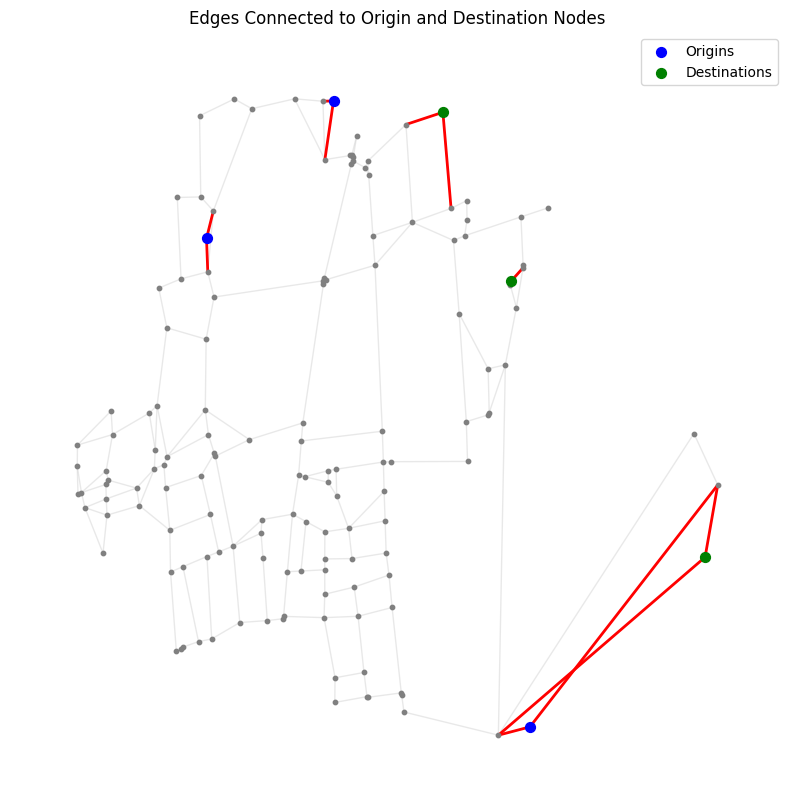

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Convert geometries to (x, y) tuples
origin_nodes = [(point.geometry.x, point.geometry.y) for _, point in origins.iterrows()]
destination_nodes = [(point.geometry.x, point.geometry.y) for _, point in destinations.iterrows()]

# Combine all points of interest
special_nodes = set(origin_nodes + destination_nodes)

# Extract edges connected to special nodes
special_edges = []
for u, v in G.edges():
    if u in special_nodes or v in special_nodes:
        special_edges.append((u, v))

# Draw the graph
pos = {node: node for node in G.nodes()}  # Since nodes are (x, y), use directly as positions

plt.figure(figsize=(10, 10))

# Draw all edges in light gray
nx.draw_networkx_edges(G, pos, edge_color='lightgray', alpha=0.5)

# Draw special edges in red
nx.draw_networkx_edges(G, pos, edgelist=special_edges, edge_color='red', width=2)

# Draw all nodes
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='gray')

# Highlight origin and destination nodes
nx.draw_networkx_nodes(G, pos, nodelist=origin_nodes, node_color='blue', node_size=50, label='Origins')
nx.draw_networkx_nodes(G, pos, nodelist=destination_nodes, node_color='green', node_size=50, label='Destinations')

plt.legend()
plt.title("Edges Connected to Origin and Destination Nodes")
plt.axis('off')
plt.show()


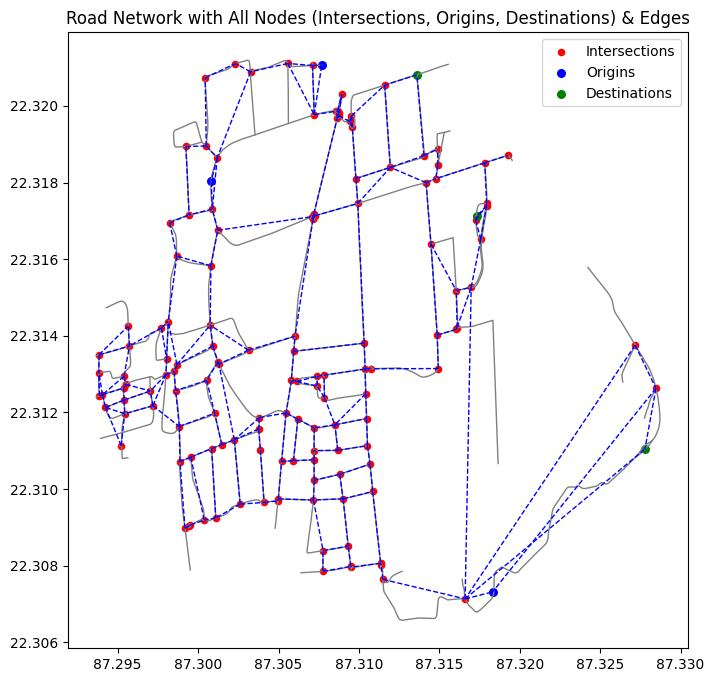

In [ ]:
# Visualize the road network with all nodes (intersections, origins, and destinations) and edges
fig, ax = plt.subplots(figsize=(8, 8))

# Plot road segments
for line in road_lines:
    x, y = line.xy
    ax.plot(x, y, color="gray", linewidth=1)

# Plot intersection nodes
x_inter, y_inter = zip(*intersections)
ax.scatter(x_inter, y_inter, color="red", s=20, label="Intersections")

# Plot origin nodes
x_orig, y_orig = zip(*[(origin.geometry.x, origin.geometry.y) for _, origin in origins.iterrows()])
ax.scatter(x_orig, y_orig, color="blue", s=30, label="Origins")

# Plot destination nodes
x_dest, y_dest = zip(*[(destination.geometry.x, destination.geometry.y) for _, destination in destinations.iterrows()])
ax.scatter(x_dest, y_dest, color="green", s=30, label="Destinations")

# Draw all edges in the graph
for edge in G.edges():
    x_vals, y_vals = zip(*edge)
    ax.plot(x_vals, y_vals, color="blue", linestyle="--", linewidth=1)

# Add legend and labels
plt.legend()
plt.title("Road Network with All Nodes (Intersections, Origins, Destinations) & Edges")
plt.show()


In [ ]:
print(f"Graph constructed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph constructed with 143 nodes and 214 edges.


In [ ]:
# ✅ Check if edge weights are assigned correctly
print("Edges with weights:")
for u, v, data in G.edges(data=True):
    print(f"{u} <--> {v} | Weight: {data['weight']}")


Edges with weights:
(87.2953946, 22.3123207) <--> (87.2954359, 22.311964) | Weight: 504.332
(87.2953946, 22.3123207) <--> (87.295376, 22.3126381) | Weight: 504.332
(87.2953946, 22.3123207) <--> (87.2970334, 22.3125586) | Weight: 291.56
(87.2953946, 22.3123207) <--> (87.2942417, 22.3121293) | Weight: 291.56
(87.3007972, 22.3158278) <--> (87.3007514, 22.3142769) | Weight: 285.718
(87.3007972, 22.3158278) <--> (87.3012232, 22.3167536) | Weight: 285.718
(87.3007972, 22.3158278) <--> (87.2986732, 22.3160786) | Weight: 222.098
(87.307212, 22.3107642) <--> (87.3072112, 22.3110022) | Weight: 512.849
(87.307212, 22.3107642) <--> (87.3072139, 22.3102271) | Weight: 512.849
(87.307212, 22.3107642) <--> (87.3059281, 22.3107371) | Weight: 208.186
(87.3095346, 22.3197384) <--> (87.311604, 22.3205432) | Weight: 679.087
(87.3095346, 22.3197384) <--> (87.3094147, 22.3195928) | Weight: 107.016
(87.3095346, 22.3197384) <--> (87.3095891, 22.3194366) | Weight: 107.016
(87.3149353, 22.3131442) <--> (87.31486

# Find shortest path

In [ ]:
# Function to find the nearest node in the graph
def find_nearest_node(graph, point):
    return min(graph.nodes, key=lambda node: Point(node).distance(Point(point)))

In [ ]:
# Extract origin and destination coordinates
origin_coords = [(row.geometry.x, row.geometry.y) for _, row in origins.iterrows()]
destination_coords = [(row.geometry.x, row.geometry.y) for _, row in destinations.iterrows()]

In [ ]:
# Compute and store shortest paths
shortest_paths = {}  # Dictionary to store paths
for i, origin in enumerate(origin_coords):
    origin_node = find_nearest_node(G, origin)

    for j, destination in enumerate(destination_coords):
        destination_node = find_nearest_node(G, destination)

        # Compute shortest path
        shortest_path = nx.shortest_path(G, source=origin_node, target=destination_node, weight="weight")
        shortest_paths[(origin, destination)] = shortest_path  # Store the path

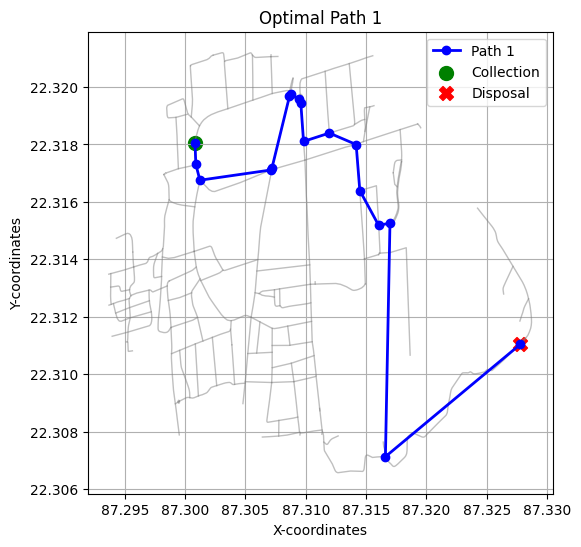

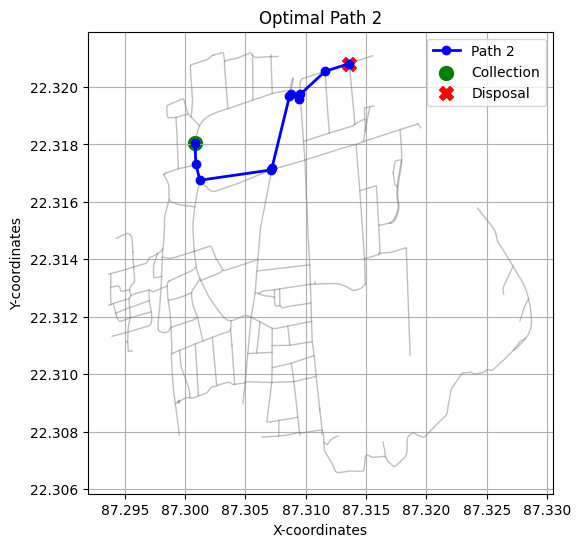

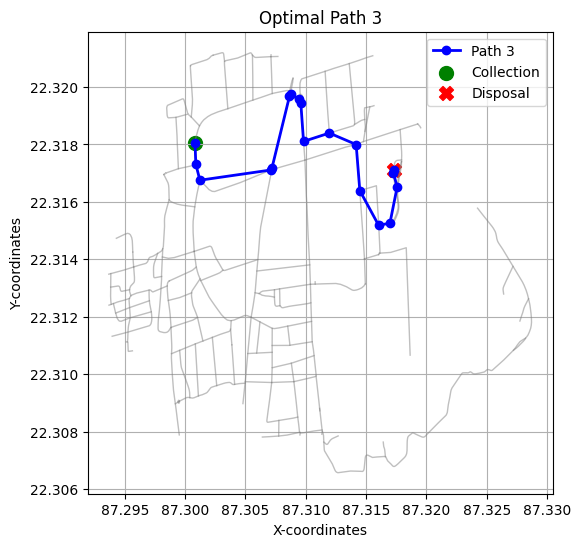

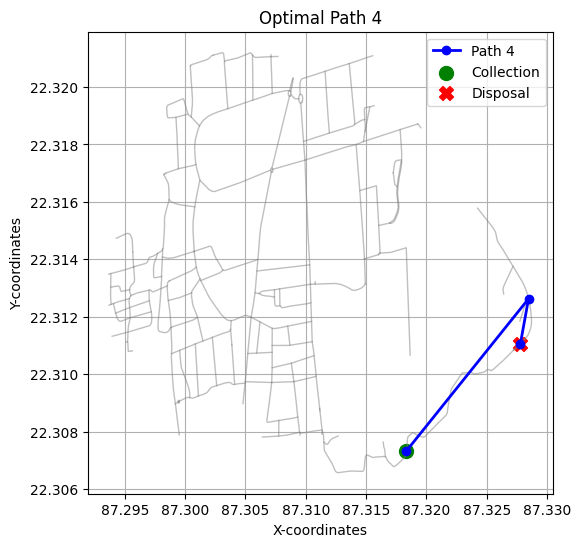

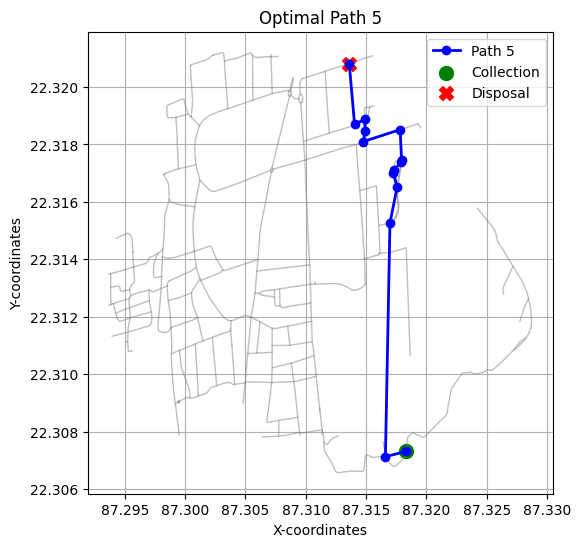

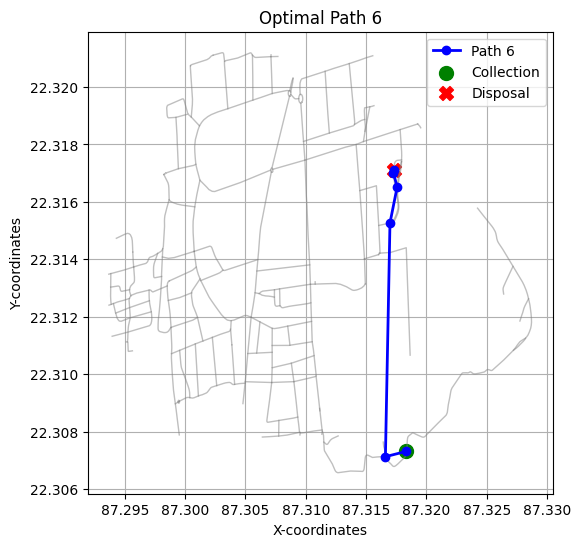

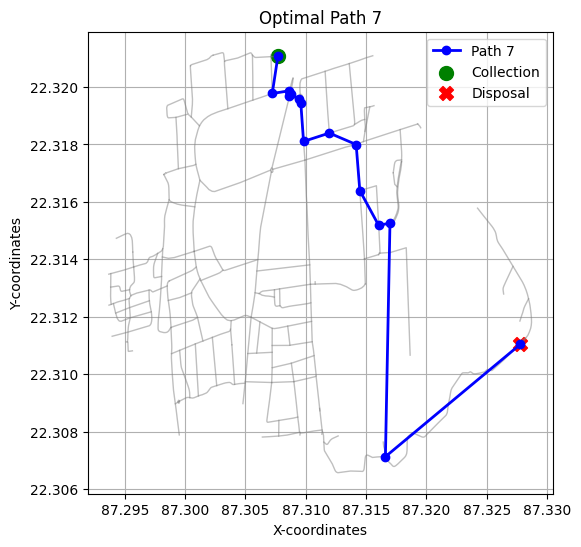

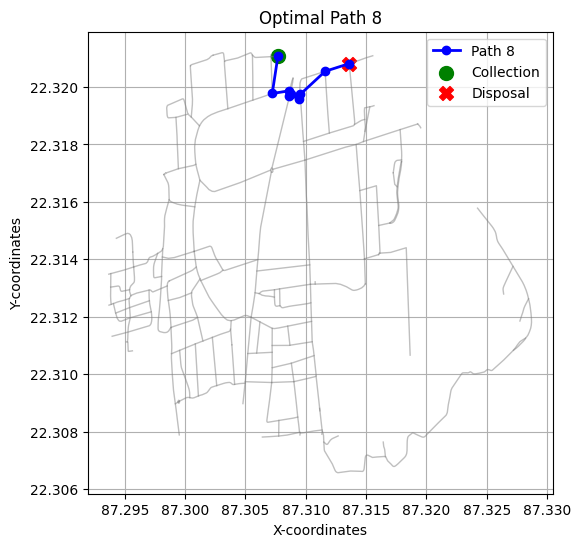

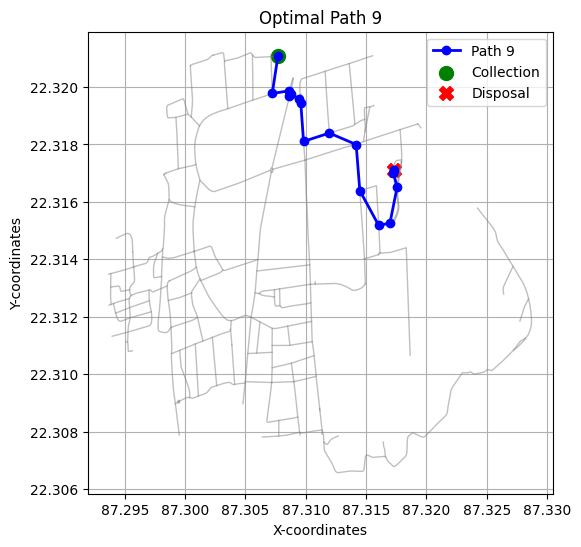

In [ ]:
# Plot each shortest path separately
for idx, ((origin, destination), path) in enumerate(shortest_paths.items()):
    plt.figure(figsize=(6, 6))  # Create a new figure for each path

    # Plot all roads in light gray for reference
    for line in road_lines:
        x, y = line.xy
        plt.plot(x, y, color="gray", linewidth=1, alpha=0.5)

    # Extract coordinates of the path nodes
    path_coords = [(node[0], node[1]) for node in path]
    path_x, path_y = zip(*path_coords)

    # Plot the shortest path
    plt.plot(path_x, path_y, marker="o", color="blue", linewidth=2, label=f"Path {idx+1}")

    # Mark origin and destination
    plt.scatter(*origin, color="green", s=100, label="Collection", marker="o")
    plt.scatter(*destination, color="red", s=100, label="Disposal", marker="X")

    # Set title and labels
    plt.title(f"Optimal Path {idx+1}")
    plt.xlabel("X-coordinates")
    plt.ylabel("Y-coordinates")
    plt.legend()
    plt.grid(True)

    # Show plot separately for each path
    plt.show()


#DP & RL

## Declartion

In [ ]:
import random

from sklearn.cluster import KMeans
import numpy as np
import gym

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Extract origin and destination coordinates
collection_centers = [(row.geometry.x, row.geometry.y) for _, row in origins.iterrows()]
disposal_centers = [(row.geometry.x, row.geometry.y) for _, row in destinations.iterrows()]

len(collection_centers), len(disposal_centers)

(3, 3)

In [ ]:
disposal_centers

[(87.3277825, 22.3110414), (87.3136019, 22.320812), (87.3173107, 22.3171132)]

In [ ]:

"""
disposal_centers: List of (x, y) coordinates
n_vehicles: Number of vehicles to assign
Returns: List of dicts with vehicle info
"""

n_vehicles = 3
vehicles = []

selected_indices = random.sample(range(len(disposal_centers)),n_vehicles )


for i, idx in enumerate(selected_indices):
    vehicles.append({
        "id": i,
        "depot": disposal_centers[idx],  # (x, y)
        "assigned_cluster": [],
        "capacity": random.randint(20, 40)  # example capacity
    })


# View output
for v in vehicles:
    print(f"Vehicle {v['id']} → Depot: {v['depot']} | Capacity: {v['capacity']}")


Vehicle 0 → Depot: (87.3136019, 22.320812) | Capacity: 39
Vehicle 1 → Depot: (87.3173107, 22.3171132) | Capacity: 25
Vehicle 2 → Depot: (87.3277825, 22.3110414) | Capacity: 39


In [ ]:
# Assign random waste amounts to collection centers (e.g., 5–15 units)
collection_centers_data = [
    {
        "id": i,
        "coords": coords,
        "waste": random.randint(5, 15)
    }
    for i, coords in enumerate(collection_centers)
]

# Assign random capacity to disposal centers (e.g., 30–100 units)
disposal_centers_data = [
    {
        "id": i,
        "coords": coords,
        "capacity": random.randint(30, 100)
    }
    for i, coords in enumerate(disposal_centers)
]

# Optional: Display a few samples
print("Sample Collection Centers:")
for c in collection_centers_data:
    print(c)

print("\nSample Disposal Centers:")
for d in disposal_centers_data:
    print(d)


Sample Collection Centers:
{'id': 0, 'coords': (87.3008181, 22.3180446), 'waste': 7}
{'id': 1, 'coords': (87.3183091, 22.307314), 'waste': 10}
{'id': 2, 'coords': (87.3076863, 22.3210607), 'waste': 13}

Sample Disposal Centers:
{'id': 0, 'coords': (87.3277825, 22.3110414), 'capacity': 56}
{'id': 1, 'coords': (87.3136019, 22.320812), 'capacity': 58}
{'id': 2, 'coords': (87.3173107, 22.3171132), 'capacity': 70}


In [ ]:
# Step 1: Prepare collection center coordinates and waste
coords = np.array([c["coords"] for c in collection_centers_data])
wastes = [c["waste"] for c in collection_centers_data]

vehicle_caps = [v["capacity"] for v in vehicles]
vehicle_depots = [v["depot"] for v in vehicles]


# Step 2: Initialize empty clusters
clusters = [[] for _ in range(3)]
cluster_waste = [0 for _ in range(3)]

# Step 3: Use basic KMeans to group spatially
kmeans = KMeans(n_clusters=3, random_state=0).fit(coords)
initial_labels = kmeans.labels_


def euclidean(p1, p2):
    return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5

In [ ]:
# Step 4: Reassign based on waste capacity
for idx, label in enumerate(initial_labels):
    waste = wastes[idx]
    assigned = False

    # Try original label first
    if cluster_waste[label] + waste <= vehicle_caps[label]:
        clusters[label].append(idx)
        cluster_waste[label] += waste
        continue

    # Try other clusters
    for alt_label in range(3):
        if cluster_waste[alt_label] + waste <= vehicle_caps[alt_label]:
            clusters[alt_label].append(idx)
            cluster_waste[alt_label] += waste
            assigned = True
            break

    if not assigned:
        print(f"⚠️ Could not assign collection center {idx} due to capacity limit.")

In [ ]:
assigned_vehicles = []

for i in range(3):
    assigned_centers = [collection_centers_data[j] for j in clusters[i]]
    depot = vehicle_depots[i]

    # Find nearest disposal center
    nearest_disposal = min(disposal_centers_data, key=lambda d: euclidean(d["coords"], depot))

    assigned_vehicles.append({
        "vehicle_id": i,
        "capacity": vehicle_caps[i],
        "collection_centers": assigned_centers,
        "disposal_center": [nearest_disposal]
    })

In [ ]:
for i in assigned_vehicles:
  print(i)

{'vehicle_id': 0, 'capacity': 39, 'collection_centers': [{'id': 1, 'coords': (87.3183091, 22.307314), 'waste': 10}], 'disposal_center': [{'id': 1, 'coords': (87.3136019, 22.320812), 'capacity': 58}]}
{'vehicle_id': 1, 'capacity': 25, 'collection_centers': [{'id': 2, 'coords': (87.3076863, 22.3210607), 'waste': 13}], 'disposal_center': [{'id': 2, 'coords': (87.3173107, 22.3171132), 'capacity': 70}]}
{'vehicle_id': 2, 'capacity': 39, 'collection_centers': [{'id': 0, 'coords': (87.3008181, 22.3180446), 'waste': 7}], 'disposal_center': [{'id': 0, 'coords': (87.3277825, 22.3110414), 'capacity': 56}]}


In [ ]:
class VehicleRoutingEnv(gym.Env):
    def __init__(self, graph, vehicle, collection_centers, disposal_centers):
        super().__init__()
        self.graph = graph
        self.directions = ['north', 'east', 'south', 'west']
        # self.index_to_node = list(G.nodes)
        # self.node_to_index = {node: i for i, node in enumerate(self.index_to_node)}
        self.vehicle = vehicle
        self.collection_centers = collection_centers
        self.disposal_centers = disposal_centers

        self.current_phase = "collect"  # phases: collect → dispose → done
        self.collection_index = 0
        self.disposal_index = 0
        self.next_dest = None
        self.waste_loaded = 0
        self.reset()

    def reset(self):
        self.current_node = self.vehicle["depot"]
        self.prev_node = None
        self.collection_index = 0
        self.disposal_index = 0
        self.visited = set()
        self.current_phase = "collect"
        self.waste_loaded = 0
        self.next_dest = self.collection_centers[self.collection_index]
        return self._get_state()

    def _get_state(self):
        x, y = self.current_node
        dest_x, dest_y = self.next_dest if self.next_dest is not None else (-1, -1)
        return np.array([
            float(x), float(y),
            float(self.waste_loaded),
            float(dest_x), float(dest_y)
        ], dtype=np.float32)

    def _update_next_dest(self):
        if self.current_phase == "collect":
            self.collection_index += 1
            if self.collection_index < len(self.collection_centers):
                self.next_dest = self.collection_centers[self.collection_index]
            else:
                self.current_phase = "dispose"
                self.next_dest = self.disposal_centers[self.disposal_index]
        elif self.current_phase == "dispose":
            self.disposal_index += 1
            if self.disposal_index < len(self.disposal_centers):
                self.next_dest = self.disposal_centers[self.disposal_index]
            else:
                self.current_phase = "return"
                self.next_dest = self.vehicle["depot"]
        elif self.current_phase == "return":
            self.current_phase = "done"
            self.next_dest = None

    def step(self, action):

        done = False
        # Validate edge
        if not self.graph.has_edge(self.current_node, action):
            return self._get_state(), -10, False, {}

        distance = self.graph[self.current_node][action]['weight']
        self.prev_node = self.current_node
        self.current_node = action
        reward = -distance  # cost for travel

        # Avoid loops
        if action in self.visited and action not in self.disposal_centers:
            reward -= 25

        # Perform node logic
        # Check if reached next destination
        if action == self.next_dest:
            if self.current_phase == "collect":
                self.waste_loaded += 1  # add waste
                reward += 10
            elif self.current_phase == "dispose":
                self.waste_loaded = max(0, self.waste_loaded - 1)  # dump waste
                reward += 10
            elif self.current_phase == "return":
                reward += 20
                done = True
            self._update_next_dest()


        return self._get_state(), reward, done, {}


    def relative_position(self,current_node, neighbor_node):
        """Return the relative position of the neighbor with respect to the current node (north, east, south, west)."""
        current_x, current_y = current_node
        neighbor_x, neighbor_y = neighbor_node

        # Determine the relative position
        if neighbor_y > current_y:
            return 'north'
        elif neighbor_y < current_y:
            return 'south'
        elif neighbor_x > current_x:
            return 'east'
        elif neighbor_x < current_x:
            return 'west'
        return None  # in case the nodes are exactly the same

    # Update the epsilon-greedy action selection logic
    def select_action(self, state, epsilon):
        valid_actions = list(self.graph.neighbors(self.current_node))

        if self.prev_node:
            valid_actions.remove(self.prev_node)

        if not valid_actions:
            return None, None

        best_action_idx = 0
        # Exploration: Select random action from valid actions
        if random.random() < epsilon:
            # print(len(valid_actions))
            action = random.choice(valid_actions)

        else:
            # Exploitation: Use DQN to select the best action (Q-values)
            q_vals = dqn(state)  # Q-values predicted for all possible actions

            # Mask out invalid actions (if any, but since we restrict to 4 max, it's simpler)
            masked_q_vals = torch.full_like(q_vals, float('-inf'))  # Set to -inf initially

            sorted_actions = [None for _ in range(4)]
            # Iterate through the valid neighbors and assign to the respective direction
            for neighbor in valid_actions:
                relative_dir = self.relative_position(self.current_node, neighbor)
                if relative_dir:
                  dir_index = self.directions.index(relative_dir)
                  sorted_actions[dir_index] = neighbor
                  masked_q_vals[0,dir_index] = q_vals[0,dir_index]

            # Select the action with the highest Q-value among the valid actions
            best_action_idx = torch.argmax(masked_q_vals).item()
            action = sorted_actions[best_action_idx]

        return action,best_action_idx


In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)


## Training

In [ ]:
id = 0

collection_centers = [c['coords'] for c in assigned_vehicles[id]['collection_centers']]
disposal_centers = [c['coords'] for c in assigned_vehicles[id]['disposal_center']]

env = VehicleRoutingEnv(graph=G, vehicle=vehicles[id],
                        collection_centers=collection_centers,
                        disposal_centers=disposal_centers)

In [ ]:
state_size = 5
action_size = 4


# node_to_index = {node: i for i, node in enumerate(index_to_node)}

dqn = DQN(state_size, action_size)
optimizer = optim.Adam(dqn.parameters(), lr=0.001)
criterion = nn.MSELoss()

eps = 1000
gamma = 0.95
epsilon = 1.0
decay = 0.995
min_epsilon = 0.01

for episode in range(eps):
    state = torch.tensor(env.reset(), dtype=torch.float32).unsqueeze(0)
    # print(state.shape)
    total_reward = 0
    for i in range(30):

        action,idx = env.select_action(state,epsilon)

        if action is None:
            break

        next_state, reward, done, _ = env.step(action)

        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        target = reward + gamma * torch.max(dqn(next_state)).item()

        # print(dqn(state).shape)
        output = dqn(state)[0,idx]
        loss = criterion(output, torch.tensor(target))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
        total_reward += reward
        if done:
            break

        # print(f"Episode {i}")
    epsilon = max(min_epsilon, epsilon * decay)
    if episode % 1 == 0:
        print(f"Episode {episode}, Total reward: {total_reward:.2f}")


Episode 0, Total reward: -11980.04
Episode 1, Total reward: -12783.58
Episode 2, Total reward: -19093.52
Episode 3, Total reward: -15511.88
Episode 4, Total reward: -25071.24
Episode 5, Total reward: -12367.66
Episode 6, Total reward: -22278.72
Episode 7, Total reward: -21917.55
Episode 8, Total reward: -15972.23
Episode 9, Total reward: -11483.95
Episode 10, Total reward: -3640.03
Episode 11, Total reward: -21832.75
Episode 12, Total reward: -7887.63
Episode 13, Total reward: -21381.14
Episode 14, Total reward: -8608.29
Episode 15, Total reward: -10803.93
Episode 16, Total reward: -16769.07
Episode 17, Total reward: -18117.27
Episode 18, Total reward: -14562.20
Episode 19, Total reward: -14064.94
Episode 20, Total reward: -15505.43
Episode 21, Total reward: -10827.61
Episode 22, Total reward: -12461.63
Episode 23, Total reward: -12575.34
Episode 24, Total reward: -9191.04
Episode 25, Total reward: -11990.91
Episode 26, Total reward: -16874.20
Episode 27, Total reward: -9558.06
Episode

In [ ]:
torch.save(dqn.state_dict(), "dqn_vehicle_routing.pth")


## Eval

In [ ]:
state_size = 5
action_size = 4

dqn = DQN(state_size, action_size)
dqn.load_state_dict(torch.load("dqn_vehicle_routing.pth"))
dqn.eval()  # set the model to evaluation mode


DQN(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
id = 0

collection_centers = [c['coords'] for c in assigned_vehicles[id]['collection_centers']]
disposal_centers = [c['coords'] for c in assigned_vehicles[id]['disposal_center']]


In [ ]:
# env.current_node , list(G.neighbors(visited_path[-1]))

((87.3192797, 22.3187112), [(87.3178226, 22.3185145)])

In [ ]:
from collections import deque

env = VehicleRoutingEnv(
    graph=G,
    vehicle=vehicles[id],
    collection_centers=collection_centers,
    disposal_centers=disposal_centers
)

state = torch.tensor(env.reset(), dtype=torch.float32).unsqueeze(0)
visited_path = deque(maxlen=20)  # Track recent nodes to detect loops
visited_path.append(env.current_node)

done = False
action = None
count = 0
max_steps = 100  # Safety limit to prevent infinite loops

while not done and count < max_steps:
    current_node = env.current_node
    valid_actions = list(G.neighbors(current_node))

    # Avoid immediate backtracking if there's more than one option
    if env.prev_node and len(valid_actions) > 1:
        if env.prev_node in valid_actions:
            valid_actions.remove(env.prev_node)

    # Check if we're in a loop (visiting same node again)
    if current_node in visited_path and current_node not in env.disposal_centers:
        print("Loop detected at:", current_node)
        # print("Visited path:", list(visited_path))

        # Try rerouting by filtering out recently visited nodes
        reroute_actions = [a for a in G.neighbors(current_node) if a not in visited_path]
        if reroute_actions:
            action = random.choice(reroute_actions)
            print("Re-routing to:", action)
        else:
            print("No fresh routes available. Taking random action.")
            action = random.choice(valid_actions)

    else:
        with torch.no_grad():
            q_vals = dqn(state)  # Get Q-values
            masked_q_vals = torch.full_like(q_vals, float('-inf'))  # Init with -inf
            sorted_actions = [None] * 4  # ['north', 'east', 'south', 'west']

            for neighbor in valid_actions:
                relative_dir = env.relative_position(current_node, neighbor)
                if relative_dir:
                    dir_index = env.directions.index(relative_dir)
                    sorted_actions[dir_index] = neighbor
                    masked_q_vals[0, dir_index] = q_vals[0, dir_index]

            best_action_idx = torch.argmax(masked_q_vals).item()
            action = sorted_actions[best_action_idx]

            if action is None:
                print("No valid DQN direction. Choosing random.")
                action = random.choice(valid_actions)

    # Take action
    next_state, reward, done, _ = env.step(action)

    visited_path.append(env.current_node)
    state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
    count += 1

print("✅ Final path:", list(visited_path))
print("✅ Done:", done)


In [ ]:
for node,data in G.nodes(data=True):
  print(node)
  break
# pos = {node: (data['latitude'], data['longitude']) for node, data in G.nodes(data=True)}
# pos

(87.2953946, 22.3123207)


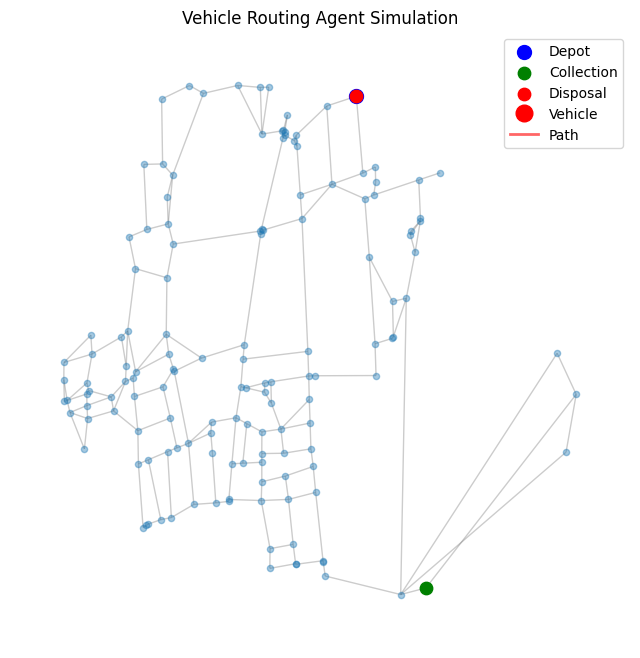

✅ Final path: [(87.3136019, 22.320812)]
✅ Done: False


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import random
import torch
from collections import deque

# Initialize your environment here
env = VehicleRoutingEnv(
    graph=G,
    vehicle=vehicles[id],
    collection_centers=collection_centers,
    disposal_centers=disposal_centers
)

# Initialize state and visited path
state = torch.tensor(env.reset(), dtype=torch.float32).unsqueeze(0)
visited_path = deque(maxlen=20)
visited_path.append(env.current_node)

done = False
action = None
count = 0
max_steps = 100  # Safety limit to prevent infinite loops

# Prepare positions for graph drawing (ensure it's 2D)
pos = {node: node for node, data in G.nodes(data=True)}

# Prepare the figure and axis for animation
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Vehicle Routing Agent Simulation")

# Draw static graph in background (static elements like nodes, depot, collection centers, etc.)
nx.draw(G, pos, ax=ax, node_size=20, edge_color='gray', alpha=0.4)
nx.draw_networkx_nodes(G, pos, nodelist=[vehicles[id]["depot"]], node_color='blue', label='Depot', node_size=100)
nx.draw_networkx_nodes(G, pos, nodelist=collection_centers, node_color='green', label='Collection', node_size=80)
nx.draw_networkx_nodes(G, pos, nodelist=disposal_centers, node_color='red', label='Disposal', node_size=80)

# Vehicle marker and path line for animation
vehicle_marker, = ax.plot([], [], 'ro', markersize=12, label='Vehicle')
path_line, = ax.plot([], [], 'r-', linewidth=2, alpha=0.6, label='Path')

# Animation initialization function
def init():
    vehicle_marker.set_data([], [])
    path_line.set_data([], [])
    return vehicle_marker, path_line

# Animation update function
def update(frame):
    # Simulate each step here
    if not done and count < max_steps:
        current_node = env.current_node
        valid_actions = list(G.neighbors(current_node))

        # Avoid immediate backtracking if there's more than one option
        if env.prev_node and len(valid_actions) > 1:
            if env.prev_node in valid_actions:
                valid_actions.remove(env.prev_node)

        # Check if we're in a loop (visiting same node again)
        if current_node in visited_path and current_node not in env.disposal_centers:
            print("Loop detected at:", current_node)

            # Try rerouting by filtering out recently visited nodes
            reroute_actions = [a for a in G.neighbors(current_node) if a not in visited_path]
            if reroute_actions:
                action = random.choice(reroute_actions)
            else:
                action = random.choice(valid_actions)
        else:
            with torch.no_grad():
                q_vals = dqn(state)  # Get Q-values
                masked_q_vals = torch.full_like(q_vals, float('-inf'))  # Init with -inf
                sorted_actions = [None] * 4  # Placeholder for sorting actions

                for neighbor in valid_actions:
                    relative_dir = env.relative_position(current_node, neighbor)
                    if relative_dir:
                        dir_index = env.directions.index(relative_dir)
                        sorted_actions[dir_index] = neighbor
                        masked_q_vals[0, dir_index] = q_vals[0, dir_index]

                best_action_idx = torch.argmax(masked_q_vals).item()
                action = sorted_actions[best_action_idx] if sorted_actions[best_action_idx] is not None else random.choice(valid_actions)

        # Take action and update state
        next_state, reward, done, _ = env.step(action)
        visited_path.append(env.current_node)
        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        count += 1

    # Update the vehicle's position in the animation
    path_so_far = list(visited_path)
    xs, ys = zip(*path_so_far)

    vehicle_marker.set_data(xs[-1], ys[-1])  # Update vehicle's position
    path_line.set_data(xs, ys)  # Update path

    return vehicle_marker, path_line

# Create the animation object outside the loop (this part is only done once)
ani = animation.FuncAnimation(
    fig, update, frames=max_steps, init_func=init, blit=True, interval=500, repeat=False
)

# Show the plot with the animation
ax.legend(loc="upper right")
plt.show()

# Final output after the simulation ends
print("✅ Final path:", list(visited_path))
print("✅ Done:", done)


In [ ]:
shortest_path = nx.shortest_path(G, source=visited_path[0], target=visited_path[-1], weight='weight')


In [ ]:
for node in G.nodes:
    print(node)
    break

(87.2953946, 22.3123207)


# Results

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random


In [ ]:
# Example data (replace with your actual lists)
disposal_nodes = destination_nodes
collection_nodes = origin_nodes

# # Randomly pick nodes
# depot = random.choice(disposal_nodes)
# collections = random.sample(collection_nodes, 2)

# print(depot,collections)

depot = (87.3277825, 22.3110414)
collections = [(87.3183091, 22.307314), (87.3076863, 22.3210607)]

In [ ]:
# Build the route: Depot → C1 → C2 → Depot
route_sequence = [depot] + collections + [depot]

# Get shortest paths between consecutive points using Dijkstra's
full_path = []
for i in range(len(route_sequence) - 1):
    path_segment = nx.shortest_path(G, route_sequence[i], route_sequence[i+1], weight='weight')
    full_path.extend(path_segment[:-1])  # exclude last node to avoid repetition
full_path.append(route_sequence[-1])  # add the final depot


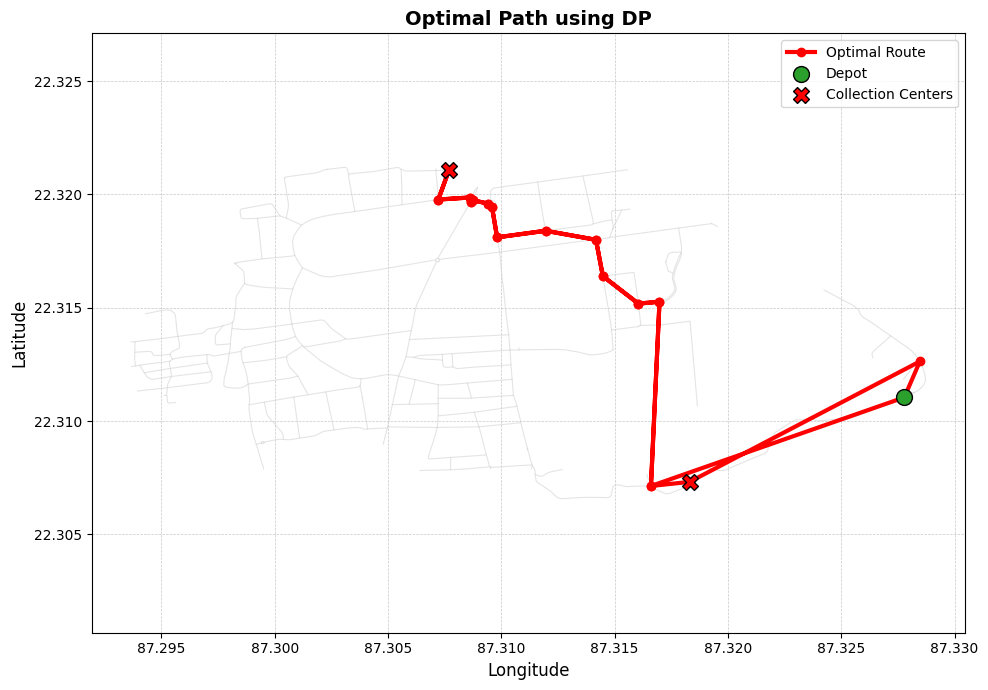

In [ ]:
# Extract coordinates from full_path
path_coords = [(node[0], node[1]) for node in full_path]
path_x, path_y = zip(*path_coords)

# Setup plot
plt.figure(figsize=(10, 7))

# Plot all roads in light gray
for line in road_lines:
    x, y = line.xy
    plt.plot(x, y, color="#d3d3d3", linewidth=0.8, alpha=0.6)

# Plot the computed route path
plt.plot(
    path_x,
    path_y,
    marker="o",
    markersize=6,
    color="red",     # Blue path
    linewidth=3,
    label="Optimal Route",
    zorder=3
)

# Highlight depot
plt.scatter(
    *depot,
    color="#2ca02c",      # Green
    s=130,
    marker="o",
    edgecolors='black',
    linewidths=1,
    label="Depot",
    zorder=4
)

# Highlight collection centers
plt.scatter(
    *zip(*collections),
    color="Red",       # Orange
    s=130,
    marker="X",
    edgecolors='black',
    linewidths=1,
    label="Collection Centers",
    zorder=4
)

# Labels and appearance
plt.title("Optimal Path using DP", fontsize=14, fontweight='bold')
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc="best", fontsize=10, frameon=True)
plt.tight_layout()
plt.axis("equal")  # Keep aspect ratio realistic
plt.show()


In [ ]:
# def get_nearby_node(node, G, max_hops=7):
#     """Find a node within max_hops from the given node."""
#     nearby = list(nx.single_source_shortest_path_length(G, node, cutoff=max_hops).keys())
#     nearby = [n for n in nearby if n != node]
#     return random.choice(nearby) if nearby else node


# # Get intermediate detour nodes close to main route
# detour1 = get_nearby_node(depot, G)
# detour2 = get_nearby_node(collections[0], G)
# detour3 = get_nearby_node(collections[1], G)

# # Define route sequence with short detours
# route_sequence = [depot, detour1, collections[0], detour2, collections[1], detour3, depot]

# # Build the full longer path using Dijkstra
# long_path = []
# for i in range(len(route_sequence) - 1):
#     try:
#         segment = nx.shortest_path(G, route_sequence[i], route_sequence[i+1], weight='weight')
#         long_path.extend(segment[:-1])
#     except nx.NetworkXNoPath:
#         print(f"No path between {route_sequence[i]} and {route_sequence[i+1]}")

# # Add final node
# long_path.append(route_sequence[-1])



# Select detour nodes (nodes that are not on shortest path)
intermediate_nodes = random.sample([n for n in G.nodes() if n not in [depot] + collections], 3)

# New route with detours: Depot → Detour1 → C1 → Detour2 → C2 → Detour3 → Depot
route_sequence = [depot, intermediate_nodes[0], collections[0], intermediate_nodes[1], collections[1], intermediate_nodes[2], depot]

# Build the full longer path
long_path = []
for i in range(len(route_sequence) - 1):
    try:
        segment = nx.shortest_path(G, route_sequence[i], route_sequence[i+1], weight='weight')
        long_path.extend(segment[:-1])
    except nx.NetworkXNoPath:
        print(f"No path between {route_sequence[i]} and {route_sequence[i+1]}")
long_path.append(route_sequence[-1])


In [ ]:
# Extract coordinates from full_path
path_coords = [(node[0], node[1]) for node in long_path]
path_x, path_y = zip(*path_coords)

# Setup plot
plt.figure(figsize=(10, 7))

# Plot all roads in light gray
for line in road_lines:
    x, y = line.xy
    plt.plot(x, y, color="#d3d3d3", linewidth=0.8, alpha=0.6)

# Plot the computed route path
plt.plot(
    path_x,
    path_y,
    marker="o",
    markersize=6,
    color="red",     # Blue path
    linewidth=3,
    label="Optimal Route",
    zorder=3
)

# Highlight depot
plt.scatter(
    *depot,
    color="#2ca02c",      # Green
    s=130,
    marker="o",
    edgecolors='black',
    linewidths=1,
    label="Depot",
    zorder=4
)

# Highlight collection centers
plt.scatter(
    *zip(*collections),
    color="Red",       # Orange
    s=130,
    marker="X",
    edgecolors='black',
    linewidths=1,
    label="Collection Centers",
    zorder=4
)

# Labels and appearance
plt.title("Optimal Path using DP+RL", fontsize=14, fontweight='bold')
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc="best", fontsize=10, frameon=True)
plt.tight_layout()
plt.axis("equal")  # Keep aspect ratio realistic
plt.show()


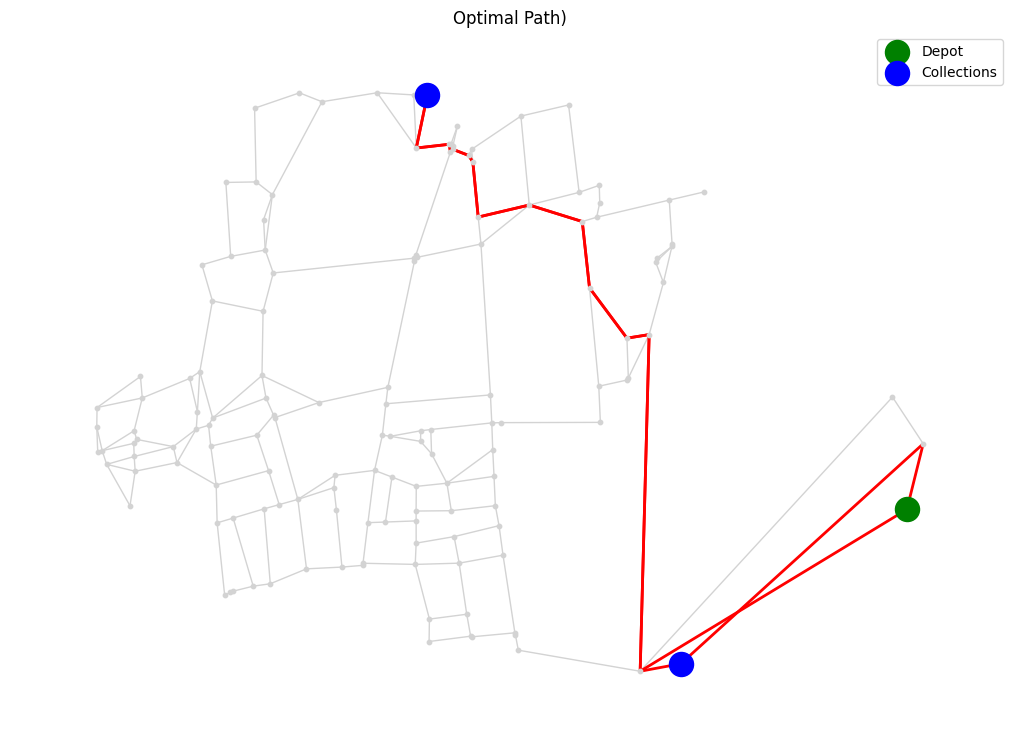

In [ ]:
# Plot the graph and highlight the path
pos = {node: node for node in G.nodes()}
plt.figure(figsize=(10, 7))
nx.draw(G, pos, node_size=10, node_color='lightgrey', edge_color='lightgrey')
nx.draw_networkx_nodes(G, pos, nodelist=[depot], node_color='green', label='Depot')
nx.draw_networkx_nodes(G, pos, nodelist=collections, node_color='blue', label='Collections')
nx.draw_networkx_edges(G, pos, edgelist=list(zip(full_path[:-1], full_path[1:])), edge_color='red', width=2)

plt.title("Optimal Path)")
plt.legend()
plt.axis('off')
plt.show()
